In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.cluster import kmeans_plusplus
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from annoy import AnnoyIndex
import torchvision
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from torchviz import make_dot
from torchsummary import summary
from IPython.display import Image
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <657200D0-E150-3B86-A0C5-7FD4B7F7C533> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Introduction
This notebook implements a simple contrastive learner. Once with a method that picks at random either a positive or a negative image to go with the anchor. 
The other method works by entering a triplet, (anchor, positive, negative). For the second scenario, we have two losses. One works the same way as the first scenrio, by calculating the cosine similarity between the anchor and both the positives and negatives. Then the mse of the cosine losses of both is added and averaged. 
The way the samples were picked originally was by choosing a positive sample as another image from the dataset thats from the same class, and negatives as an image from a different class. Since we want to show cases of self supervised learning, we will have the positives as noise applied to the anchor, and negatives to be simply chosen at random from the dataset.


### Datasets:
- The dataset im using is Mnist
- Two dataset classes, one that returns a pair of anchor and either positive or negative image, second one returns (anchor, positive, negative, pos_label=1.0, neg_label = 0.0)

In [2]:
import cv2

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.

    Args:
        image (np.ndarray): Input image.
        alpha (float): Scaling factor that controls the intensity of the deformation.
        sigma (float): Gaussian filter standard deviation.
        random_state (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Deformed image.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = np.float32(x + dx)
    map_y = np.float32(y + dy)

    return cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)


In [3]:
import torch
import numpy as np
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import Dataset

def contrastive_data_loader(dataset='mnist', class_labels_list=[0, 1], num_samples=1, normalise_data=True, isImg=True, noise_level=0.1, contrastive=True, use_class_sampling=False, elastic=True):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
    
    if dataset == 'mnist':
        # Load the MNIST dataset
        data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        print('MNIST loaded dataset', data)
        X_full = data.data.view(data.data.size(0), -1).float() / 255  # Normalize the data
        Y_full = data.targets
        x_idx = torch.tensor([]).long()
        
        # select only items from class_label
        for i in class_labels_list:
            x_idx = torch.cat((x_idx, (Y_full == i).nonzero(as_tuple=True)[0]))
            
        # randomise and cut indices
        shuffled = torch.randperm(x_idx.size(0))[:num_samples]
        indices = x_idx[shuffled]
        X = X_full[indices]
        Y = Y_full[indices]
        
        # Create a DataFrame from the selected data
        data_df = pd.DataFrame(X.numpy())
        data_df.insert(0, 'label', Y.numpy())
    return AugmentedMNISTDataset(data_df, transform=transform, contrastive=contrastive, noise_level=noise_level, use_class_sampling=use_class_sampling, elastic=elastic), X, Y

class AugmentedMNISTDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, clust_assign=None, transform=None, contrastive=True, noise_level=0.1, use_class_sampling=False, elastic=True):
        super(AugmentedMNISTDataset, self).__init__()
        self.data_df = data_df
        self.clust_assign = clust_assign
        self.transform = transform
        self.elastic_transform = elastic_transform
        self.contrastive = contrastive
        self.use_class_sampling = use_class_sampling
        self.elastic = elastic
        
    def __len__(self):
        return len(self.data_df)

    def set_clust_assign(self, clust_assign):
        self.clust_assign = clust_assign

    def __getitem__(self, idx):
        anchor_data = self.data_df.iloc[idx].to_numpy()
        anchor_image = anchor_data[1:].reshape(28, 28).astype(np.float32)
        label = anchor_data[0]

        if self.use_class_sampling:
            # Positive sample: another image from the same class
            positive_idx = idx
            while positive_idx == idx:
                positive_idx = np.random.choice(self.data_df[self.data_df['label'] == label].index)
            positive_data = self.data_df.loc[positive_idx].to_numpy()
            positive_image = positive_data[1:].reshape(28, 28).astype(np.float32)
            
            # Negative sample: pick a random image from a different cluster based on clust_assign
            negative_idx = idx
            anchor_cluster = torch.argmax(self.clust_assign[:, idx]).item()
            while negative_idx == idx or torch.argmax(self.clust_assign[:, negative_idx]).item() == anchor_cluster:
                negative_idx = np.random.randint(0, len(self.data_df))
            negative_data = self.data_df.iloc[negative_idx].to_numpy()
            negative_image = negative_data[1:].reshape(28, 28).astype(np.float32)
        else:
            anchor_cluster = torch.argmax(self.clust_assign[:, idx]).item()
            if self.elastic:
                # Positive sample: apply elastic transformation to the same image
                positive_image = self.elastic_transform(anchor_image, alpha=42, sigma=5)
            else:
                positive_idx = idx
                while positive_idx == idx or torch.argmax(self.clust_assign[:, positive_idx]).item() != anchor_cluster:
                    positive_idx = np.random.randint(0, len(self.data_df))
                positive_data = self.data_df.iloc[positive_idx].to_numpy()
                positive_image = positive_data[1:].reshape(28, 28).astype(np.float32)

            # Negative sample: pick a random different image
            negative_idx = idx
            while negative_idx == idx or torch.argmax(self.clust_assign[:, negative_idx]).item() == anchor_cluster:
                negative_idx = np.random.randint(0, len(self.data_df))
            negative_data = self.data_df.iloc[negative_idx].to_numpy()
            negative_image = negative_data[1:].reshape(28, 28).astype(np.float32)

        if self.transform is not None:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        if np.random.randint(0, 2) == 0:
            second = positive_image
            similarity = 1.0
        else:
            second = negative_image
            similarity = 0.0
        
        if self.contrastive:
            return idx, anchor_image, positive_image, negative_image, 1.0, 0.0, label
        else:
            return idx, anchor_image, second, similarity, label


In [4]:
def plot_dataset_sample(dataset, index, contrastive):

    if contrastive:
        idx, first, second, third, second_label, third_label, label = dataset[index]
        third = third.numpy().transpose((1, 2, 0))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    else:
    # Get the sample from the dataset
        idx, first, second, second_label, label = dataset[index]
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Convert tensors to numpy arrays for plotting
    first_img = first.numpy().transpose((1, 2, 0))
    second_img = second.numpy().transpose((1, 2, 0)) 

    # Plot the first image
    axes[0].imshow(first_img.squeeze(), cmap='gray')
    axes[0].set_title(f'Anchor')
    axes[0].axis('off')

    # Plot the second image
    axes[1].imshow(second_img.squeeze(), cmap='gray')
    axes[1].set_title(f'Positve Augmentation')
    axes[1].axis('off')
    # Plot the third image
    if contrastive:
        axes[2].imshow(third.squeeze(), cmap='gray')
        axes[2].set_title(f'Negative sample')
        axes[2].axis('off')

    plt.show()

#### Networks:
The network is a simple convolutional model. 

In [5]:
class Network(nn.Module):
    # Expects a 28x28 image, returns a flat embed
    def __init__(self, embed=64):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        ) # d * 32 * 12 * 12
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        ) # d * 64 * 4 * 4
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, embed),
        )

    def forward(self, x):
        x = self.conv1(x) # x: d * 32 * 12 * 12
        x = self.conv2(x) # x: d * 64 * 4  * 4 
        x = x.view(x.size(0), -1) # x: d * (64*4*4)
        x = self.linear1(x) # x: d * 64
        return x

def visualize_network(net):
    x = torch.randn(1, 1, 28, 28)  # Dummy input tensor
    y = net(x)  # Forward pass to create the computation graph
    graph = make_dot(y, params=dict(list(net.named_parameters()) + [('x', x)]))
    return graph

def summarize_model(model, input_size):
    summary(model, input_size)

# Example usage
model_summary = Network(embed=64)
summarize_model(model_summary, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
           Dropout-5           [-1, 32, 12, 12]               0
            Conv2d-6             [-1, 64, 8, 8]          51,264
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Dropout-10             [-1, 64, 4, 4]               0
           Linear-11                  [-1, 512]         524,800
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [6]:
# Example usage
net = Network()
graph = visualize_network(net)
graph.render("network_visualization", format="png")

'network_visualization.png'

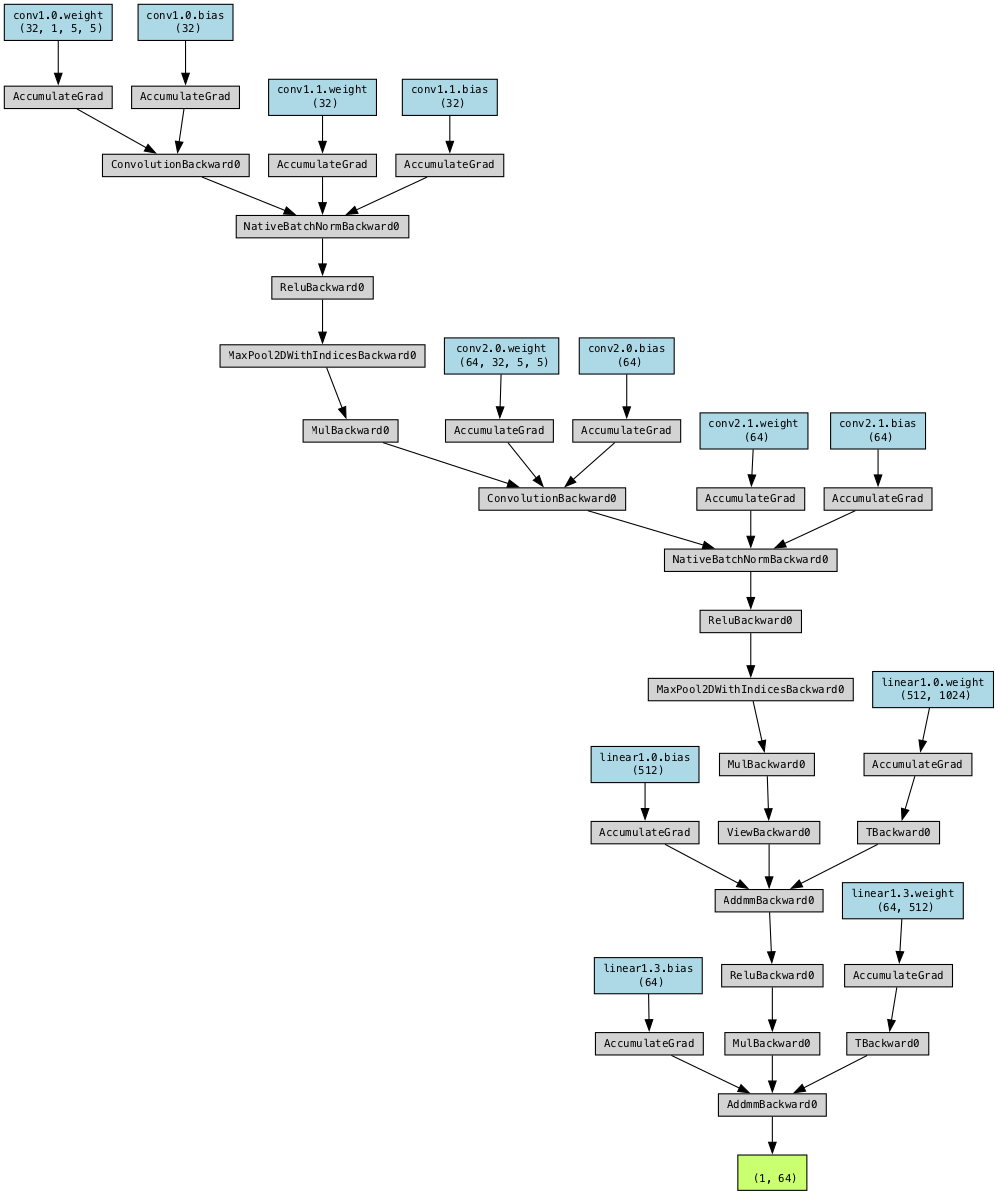

In [7]:
Image(filename="network_visualization.png")


#### Losses:
- CosineLoss: gets the cosine similarity between the anchor and the secon image (Whether positive or negative), returns the mse between the real distance (label, 1.0 if positive, 0.0 if negative).
- ContrastiveLoss: defines the Contrastive Kernel Learning loss from the paper https://arxiv.org/pdf/2309.02028 

In [8]:
class CosineLoss(nn.Module):
    # Input: [batch_size, embed]
    # Output: [batch_size]
    def __init__(self):
        super(CosineLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, first, second, distance):
        score = self.similarity(first, second)
        individual_losses = (score - distance) ** 2
        return individual_losses.float()


In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()

    def forward(self, anchors, positives, negatives):
        # Calculate (u(x^-) - u(x^+)) for all examples in the batch
        diff = negatives - positives
        # Anchor shape: [batch_size, embedding_size]
        # Calculate u(x).T * (u(x^-) - u(x^+)) for all examples in the batch
        # Resulting shape: [batch_size]
        loss_per_example = torch.sum(anchors * diff, dim=-1)
        # batch_loss = torch.mean(avg_anchor_losses) + (0.00001 * torch.square(torch.norm(anchors)))
        return loss_per_example

#### Functions for the tensorization

In [10]:
def clust_matrix(X, n_clusters, centers):
    clust = None
    for i in range(n_clusters):
        d = torch.norm(X - torch.tensor(centers[i]), dim=1).reshape(-1, 1)
        if clust is None:
            clust = d
        else:
            clust = torch.cat((clust, d), dim=1)
    clust = torch.argmin(clust, axis=1)
    # Prepare cluster assignment matrix
    clust_assign = torch.zeros([n_clusters, X.shape[0]], dtype=torch.float32)
    for i in range(X.shape[0]):
        clust_assign[clust[i], i] = 1
    return clust_assign

def update_centers(X, centers, clust_assign, batch_idx):
    centers = clust_assign.float() @ X.float()
    norm = torch.sum(clust_assign, axis=1, dtype=torch.float).reshape(-1, 1) @ torch.ones(1, X.shape[1], dtype=torch.float)
    centers_ = centers / norm
    if batch_idx == -1:
        return centers_
    return (batch_idx * centers + centers_) / (batch_idx + 1)    
def cluster(embeddings, assignments, n_clusters, method='tensor'):
    if method == 'tensor':
        return assignments
    else:  # if method is 'kmeans'
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=20)
        kmeans.fit(embeddings)
        return kmeans.labels_

#### Tensorized models:
- TensorizedContrastive is for samples that contain positive and negative augmentations

In [12]:
class TensorizedContrastive(nn.Module):
    def __init__(self, embed, loss_f, num_tensors=2, linear=True,center_points=False):
        super(TensorizedContrastive, self).__init__()
        self.linear=linear
        self.embed=embed
        self.CE = nn.ModuleList()
        # add num_clusters CE
        self.num_tensors = num_tensors
        for i in range(num_tensors):            
            self.CE.append(Network(embed))
        self.loss_f = loss_f
        self.center_points = center_points
    def get_embedding(self,X, clust_assign):
        X=X.reshape(-1, 1, 28, 28)
        batch_size = X.shape[0]
        embeddings = torch.zeros((batch_size, self.embed), device=device, dtype=torch.float)
        for j in range(self.num_tensors):
            assignments = clust_assign[j]  
            if assignments.any():
                result = X[assignments == 1]
                # Get the embeddings
                embed= self.CE[j](result)
                embeddings[assignments == 1] = embed
        return embeddings

    def forward(self, X,clust_assign, centers, cosine=False):
        # In the forward pass, X is a tuple (anchor, positive, negative) if contrastive, else (anchor, positve)
        # Then to calculate the loss, the function loops the list of tensors, and computes the loss for the whole batch 
        # The for each datapoint of the batch, the tensor that had the lowest loss will be saved and returned in best_indices
        # these will be used in the assignment matrix
        # For each tensor, only the losses of the datapoints assigned to that tensor will be added to the total loss. 
        idx, anchor, positive, negative = X[0], X[1], X[2], X[3]
        
        batch_size = anchor.shape[0]
        total_loss = torch.tensor(0, device=device, dtype=torch.float, requires_grad=True)
        embeddings = torch.zeros((batch_size, self.embed), device=device, dtype=torch.float)
        best_losses = torch.full((batch_size,), float('inf'), device=device, dtype=torch.float)
        best_indices = torch.full((batch_size,), -1, dtype=torch.long)
        
        for j in range(self.num_tensors):
            if self.center_points:
                a = anchor - centers[j]
                p = positive - centers[j]
                n = negative - centers[j]
            else:
                a = anchor
                p = positive
                n = negative
            
            a=a.reshape(-1, 1, 28, 28)
            p=p.reshape(-1, 1, 28, 28)
            n=n.reshape(-1, 1, 28, 28)
            assignments = clust_assign[j][idx]
            # Get the embeddings
            a_out, p_out, n_out = self.CE[j](a), self.CE[j](p), self.CE[j](n)
            anchor_embed= self.CE[j](anchor.reshape(-1, 1, 28, 28))
            if cosine:
                indiv_ls1 = self.loss_f(a_out, p_out, 1.0)
                indiv_ls2 = self.loss_f(a_out, n_out, 0.0)
                indiv_ls = indiv_ls1+indiv_ls2
                indiv_ls = indiv_ls / 2
            else: indiv_ls = self.loss_f(a_out, p_out, n_out)
            better_loss = indiv_ls < best_losses
            best_losses = torch.where(better_loss, indiv_ls, best_losses)
            best_indices = torch.where(better_loss, torch.full_like(best_indices, j), best_indices)
            #select only loss of tensors to which the datapoints belong
            loss = torch.dot(assignments, indiv_ls)
            has_nan = torch.isnan(loss).any()
            if not has_nan:
                total_loss = total_loss + loss 
            embeddings = torch.where(better_loss.unsqueeze(1),anchor_embed , embeddings)
        # Convert total_losses to a tensor and sum
        return total_loss/batch_size, embeddings, best_indices

#### Training function

In [21]:
def train(X_out,Y, dataloader, n_tensors,in_feature,embed,epochs=20,contrastive=True, lr=0.0001, loss_fn=CosineLoss(), cosine=True, center_points=False):
    with torch.no_grad():
        centers, indices = kmeans_plusplus(X_out.numpy(), n_clusters=n_tensors, random_state=20)
        clust_assign = clust_matrix(X_out, n_tensors, centers)
        centers = update_centers(X_out, centers, clust_assign, -1)
    centers = centers.to(device)
    train_loss = []
    lrs = []
    if contrastive:
        net = TensorizedContrastive(embed, loss_f=loss_fn, num_tensors=n_tensors,center_points=center_points)
    else:
        net = TensorizedNone(embed, loss_f=loss_fn, num_tensors=n_tensors,center_points=center_points)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    
    # Set initial clust_assign in dataloader
    dataloader.dataset.set_clust_assign(clust_assign)    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        epoch_loss = 0
        progress_bar = enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'))
        for batch_id, batch in progress_bar:
            if contrastive:
                anchor_index, anchor, second, third, scnd_dis, thrd_dis, label = batch
            else:
                anchor_index, anchor, second, scnd_dis, label = batch

            anchor = anchor.flatten(start_dim=-2)
            second = second.flatten(start_dim=-2)
            if contrastive: third = third.flatten(start_dim=-2)
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]['lr'])
            if contrastive:
                batch_loss, embeddings_, assignments = net((anchor_index, anchor, second, third), clust_assign, centers, cosine=cosine)
            else:
                batch_loss, embeddings_, assignments = net((anchor_index, anchor, second, scnd_dis), clust_assign, centers)

            epoch_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
            labels = assignments
            # for batch_size
            for k in range(len(anchor)):
                clust_assign[:, anchor_index[k]] = 0
                clust_assign[labels[k]][anchor_index[k]] = 1
            centers = update_centers(X_out, centers, clust_assign, batch_id)
            centers = centers.to(device)

            # Update clust_assign in the dataloader for the next batch
            dataloader.dataset.set_clust_assign(clust_assign)
        
        print("ARI:")
        print(adjusted_rand_score(torch.argmax(clust_assign, axis=0).cpu().detach().numpy(), Y.cpu().detach().numpy()))
        
        # Record the loss for the epoch
        loss = epoch_loss / len(dataloader)
        print('epoch ', epoch+1, ' loss ', loss)
        train_loss.append(loss)

    embeddings = net.get_embedding(X_out, clust_assign)
    
    return net, train_loss, clust_assign, embeddings.detach().numpy()


### Experiments
- ContrastiveLoss:


#### Loading the datasets:

Plotting the datasets

##### For the contrastive loss only the triplet dataset will be used.
##### Experiment 5: Vanilla

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


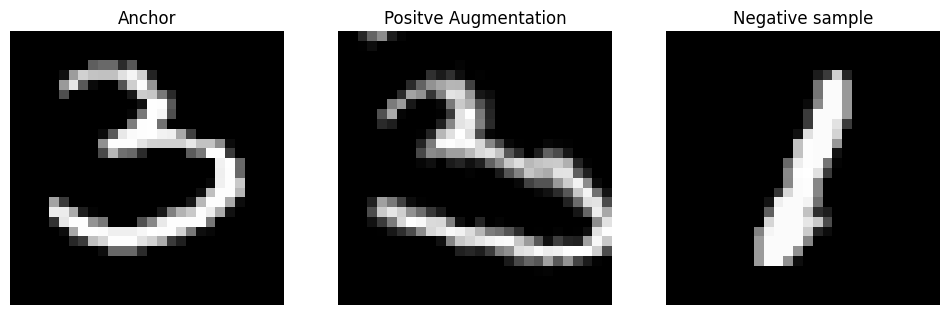

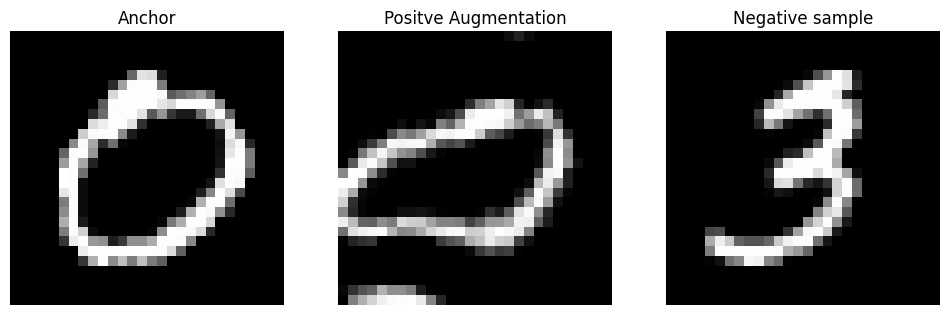

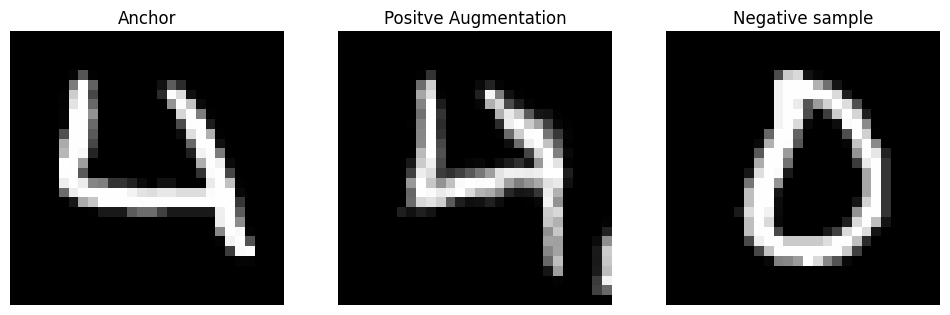

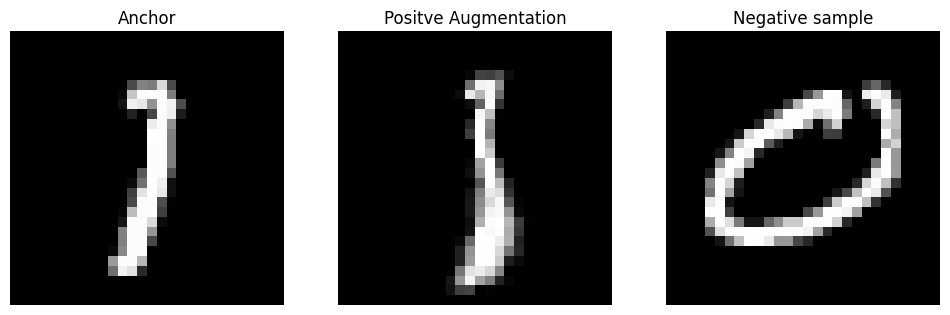

In [25]:
# False: pair of anchor and a second image, True: triplet
CONTRASTIVE = True 
EMBED = 128
BATCH = 128
NUM_SAMPLES = 1000
NUM_CLUSTERS=5
NUM_TENSORS = 5

CLASS_KNOWLEDGE = False
ELASTIC=True
CENTER = False

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic = ELASTIC
)

# Use k-means++ to initialize cluster centers
centers, indices = kmeans_plusplus(contra_X.numpy(), n_clusters=NUM_TENSORS, random_state=20)
clust_assign = clust_matrix(contra_X, NUM_TENSORS, centers)
centers = update_centers(contra_X, centers, clust_assign, -1)

# Set initial clust_assign in the dataset
contra_dataset.set_clust_assign(clust_assign)
contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)
for i in range(4):
    plot_dataset_sample(contra_dataset, i, contrastive = True)

In [15]:
EPOCHS = 20
net_5 = Network()
# define optimizer
optimizer_5 = optim.Adam(net_5.parameters(), lr=0.00001)
# define loss function
loss_function = ContrastiveLoss()

In [16]:
lrs_5 = []
losses_5 = []
scheduler = optim.lr_scheduler.StepLR(optimizer_5, step_size=40, gamma=0.85)
# torch training loop
for epoch in range(EPOCHS):
    epoch_loss = 0
    batches=0
    print('epoch -', epoch)
    lrs_5.append(optimizer_5.param_groups[0]['lr'])
    print('learning rate', lrs_5[-1])
    for idx, anchor, positive, negative, pos_dis, neg_dis, label in tqdm(contra_train_loader):
        batches+=1
        optimizer_5.zero_grad()
        anchor_out = net(anchor)
        positive_out = net(positive)
        negative_out = net(negative)
        loss = loss_function(anchor_out, positive_out, negative_out)
        loss=loss.mean()
        epoch_loss += loss.item()
        loss.backward()
        optimizer_5.step()
    
    losses_5.append(epoch_loss / batches)
    scheduler.step()
    print('epoch_loss', losses_5[-1])

epoch - 0
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.28464569337666035
epoch - 1
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.26620839443057775
epoch - 2
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3535128440707922
epoch - 3
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.39483072608709335
epoch - 4
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.28922623954713345
epoch - 5
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3691546078771353
epoch - 6
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.36109964177012444
epoch - 7
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.38258432038128376
epoch - 8
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.42868426255881786
epoch - 9
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3774820538237691
epoch - 10
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.32031472213566303
epoch - 11
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3203437738120556
epoch - 12
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3550880029797554
epoch - 13
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3224708391353488
epoch - 14
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3659167028963566
epoch - 15
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3315623439848423
epoch - 16
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.2776036150753498
epoch - 17
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.36709580197930336
epoch - 18
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.366544209420681
epoch - 19
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3458346873521805


In [18]:
def get_representations(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = X.view(-1, 1, 28, 28)  # Reshape X to (batch_size, 1, 28, 28)
        representations = model(X_tensor).detach()
    return representations
# Get the representations
representations_5 = get_representations(net_5, contra_X)

# Apply K-means clustering on original X
num_clusters = NUM_CLUSTERS
kmeans_original_5 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_original_5.fit(contra_X)
predictions_original_5 = kmeans_original_5.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_5 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_5.fit(representations_5)
predictions_representations_5 = kmeans_representations_5.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_5 = adjusted_rand_score(contra_Y, predictions_original_5)
ari_representations_5 = adjusted_rand_score(contra_Y, predictions_representations_5)

print(f'Adjusted Rand Index (ARI) for original X: {ari_original_5}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_5}')

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7532050602120666
Adjusted Rand Index (ARI) for representations: 0.6618180187731602


##### Experiment 6: Tensorized

In [22]:
experiments = {
    1: (False, CosineLoss(),True),
    2: (True, CosineLoss(),True),
    3: (True, ContrastiveLoss(),False)
}
CONTRASTIVE,loss_fn,COSINE = experiments.get(3)

ELASTIC=True
CENTER=False
CLASS_KNOWLEDGE = False

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic=ELASTIC
)

contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)


MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [23]:
net_6, train_loss_6, clust_assign_6, embeddings_6 = train(contra_X,contra_Y,contra_train_loader, n_tensors=NUM_TENSORS,in_feature=-1,embed=EMBED, contrastive=CONTRASTIVE,epochs=30, lr=0.0001,cosine=COSINE,loss_fn=loss_fn)

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.02591036318908299
epoch  1  loss  -1.8913427740335464


Epoch 2/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1090351556265001
epoch  2  loss  -3.9830841720104218


Epoch 3/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.12599693788020366
epoch  3  loss  -17.439927101135254


Epoch 4/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13177997648350873
epoch  4  loss  -84.90653324127197


Epoch 5/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.12774791022551163
epoch  5  loss  -399.77719497680664


Epoch 6/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14690364986413953
epoch  6  loss  -1603.2320861816406


Epoch 7/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1335076558516895
epoch  7  loss  -5182.429046630859


Epoch 8/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1347710022544677
epoch  8  loss  -14356.932006835938


Epoch 9/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13535601471937717
epoch  9  loss  -34870.3994140625


Epoch 10/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13822354904676756
epoch  10  loss  -74265.17919921875


Epoch 11/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1415652219433188
epoch  11  loss  -142529.9560546875


Epoch 12/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.13795479340413827
epoch  12  loss  -277876.4453125


Epoch 13/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14214971699742038
epoch  13  loss  -466625.4296875


Epoch 14/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1478599428388732
epoch  14  loss  -768723.4453125


Epoch 15/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15803085656184002
epoch  15  loss  -1253760.5625


Epoch 16/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14882131839237506
epoch  16  loss  -1883398.9375


Epoch 17/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.14694148563098536
epoch  17  loss  -2888665.625


Epoch 18/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15427655333521625
epoch  18  loss  -4133724.34375


Epoch 19/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15295288232695947
epoch  19  loss  -5790588.0


Epoch 20/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.15894112125797139
epoch  20  loss  -7882722.1875


Epoch 21/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16195703280813256
epoch  21  loss  -10399586.25


Epoch 22/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17830616475481725
epoch  22  loss  -14177731.25


Epoch 23/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.1757533231955521
epoch  23  loss  -18785510.75


Epoch 24/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18176783407386007
epoch  24  loss  -24023681.25


Epoch 25/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18823323559830962
epoch  25  loss  -30579417.0


Epoch 26/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.18107840116056884
epoch  26  loss  -38371673.5


Epoch 27/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16151595342026343
epoch  27  loss  -47960446.0


Epoch 28/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16915219338744733
epoch  28  loss  -59040631.5


Epoch 29/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17485004206564364
epoch  29  loss  -74360833.0


Epoch 30/30:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.16883801560327039
epoch  30  loss  -92187413.0


In [24]:
representations_6 = embeddings_6

# Apply K-means clustering on original X
kmeans_original_6 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_6.fit(contra_X)
predictions_original_6 = kmeans_original_6.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_6 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_representations_6.fit(representations_6)
predictions_representations_6 = kmeans_representations_6.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_6 = adjusted_rand_score(contra_Y, predictions_original_6)
ari_representations_6 = adjusted_rand_score(contra_Y, predictions_representations_6)
ari_clust_6= adjusted_rand_score(torch.argmax(clust_assign_6,axis=0).cpu().detach().numpy(), contra_Y.cpu().detach().numpy())
print(f'Adjusted Rand Index (ARI) for original X: {ari_original_6}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_6}')
print(f'Adjusted Rand Index (ARI) for clust_assign:{ari_clust_6}')


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7646810481363625
Adjusted Rand Index (ARI) for representations: 0.14222377169299194
Adjusted Rand Index (ARI) for clust_assign:0.16883801560327039


#### Visualizing the embeddings


Contrastive loss without class knowledge:


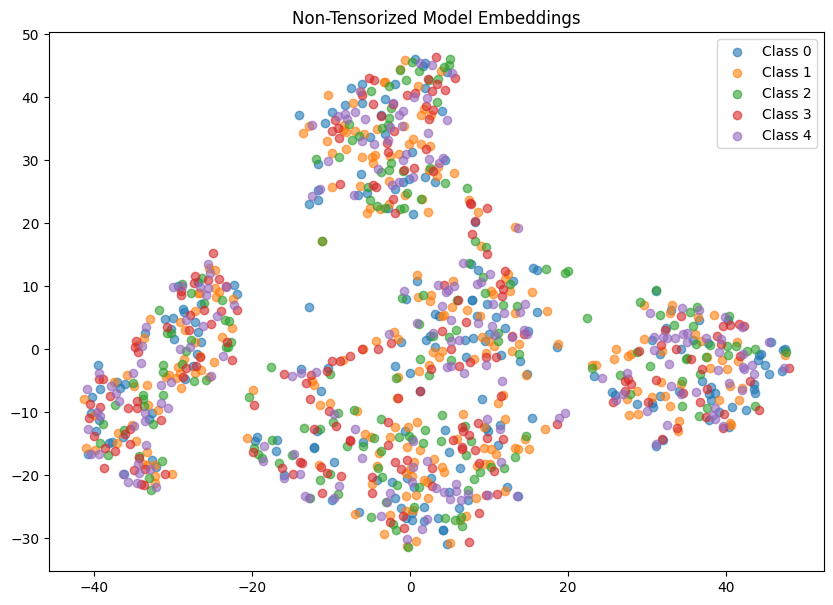

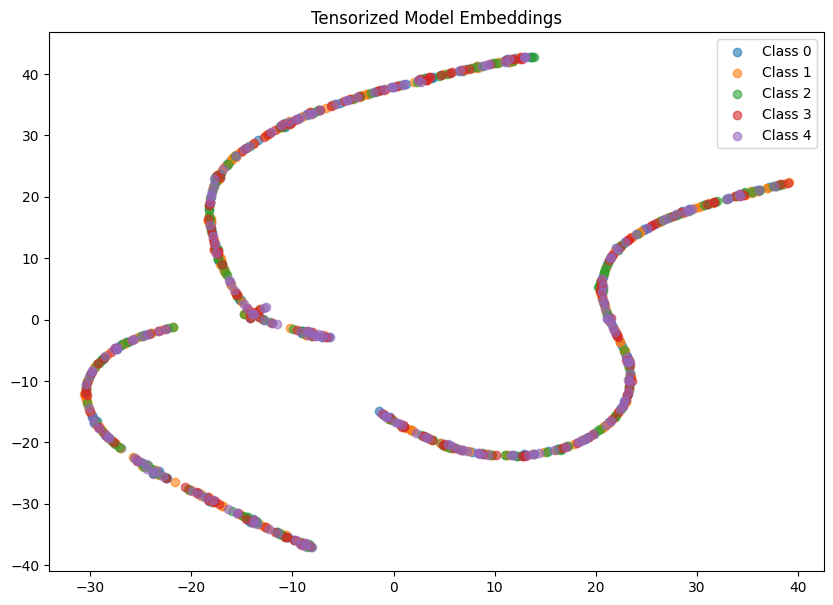

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def inspect_embeddings(embeddings, labels, title="Embeddings Visualization"):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    labels = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels  # Ensure labels are numpy array
    unique_labels = np.unique(labels)  # Get unique labels
    
    plt.figure(figsize=(10, 7))
    
    for label in unique_labels:
        idx = labels == label
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6)
    
    plt.legend()
    plt.title(title)
    plt.show()

# After training the models
print("Contrastive loss without class knowledge:")
inspect_embeddings(representations_5, contra_Y, title="Non-Tensorized Model Embeddings")
inspect_embeddings(representations_6, contra_Y, title="Tensorized Model Embeddings")


##### We observe that the clusters in the tensorized embeddings are very tight and well-separated, yet the colors within these clusters are  very mixed, it suggests that the model is forming clusters based on features that are not aligned with the true class labels.

##### If we try picking samples based on knowledge of labels, the performance improves significantly:

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


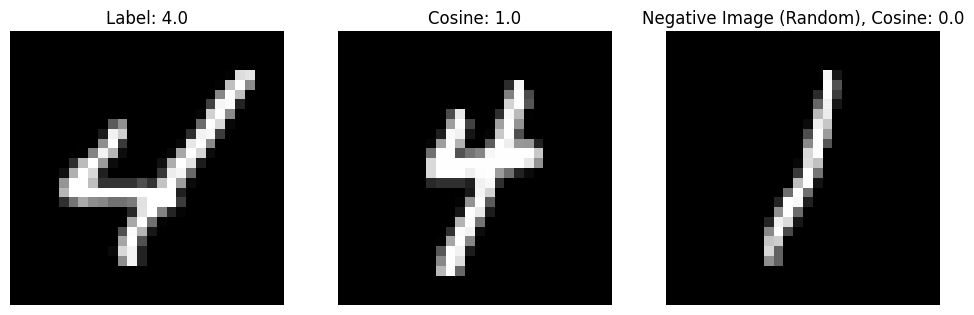

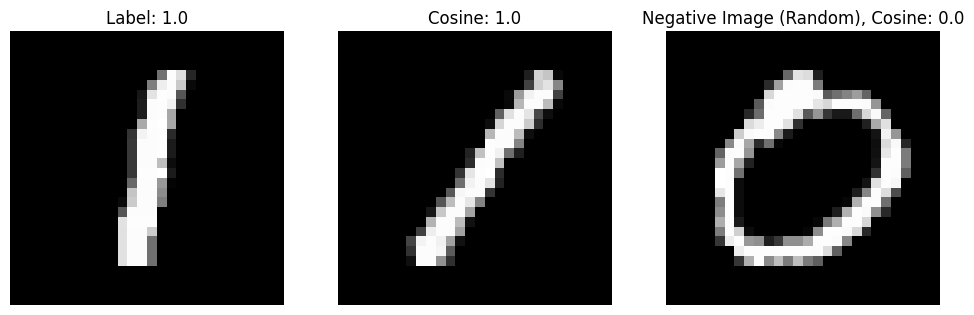

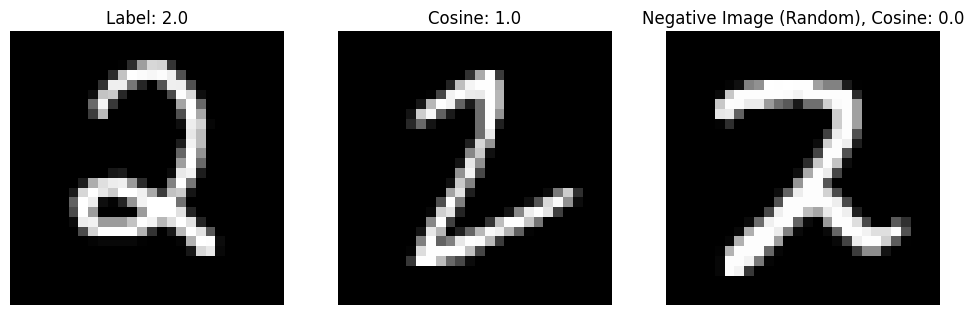

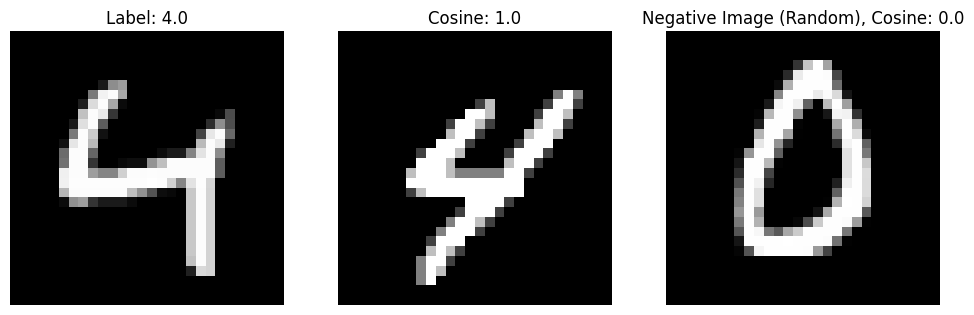

In [145]:
# False: pair of anchor and a second image, True: triplet
CONTRASTIVE = True 
EMBED = 128
BATCH = 128
NUM_SAMPLES = 1000
NUM_CLUSTERS=5
NUM_TENSORS = 5

CLASS_KNOWLEDGE = True
ELASTIC=True
CENTER = False

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic = ELASTIC
)

# Use k-means++ to initialize cluster centers
centers, indices = kmeans_plusplus(contra_X.numpy(), n_clusters=NUM_TENSORS, random_state=20)
clust_assign = clust_matrix(contra_X, NUM_TENSORS, centers)
centers = update_centers(contra_X, centers, clust_assign, -1)

# Set initial clust_assign in the dataset
contra_dataset.set_clust_assign(clust_assign)
contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)
for i in range(4):
    plot_dataset_sample(contra_dataset, i, contrastive = True)

In [27]:
EPOCHS = 25
net_5_2 = Network()
# define optimizer
optimizer_5_2 = optim.Adam(net_5_2.parameters(), lr=0.00001)
# define loss function
loss_function = ContrastiveLoss()

lrs_5_2 = []
losses_5_2 = []
scheduler = optim.lr_scheduler.StepLR(optimizer_5_2, step_size=40, gamma=0.85)
# torch training loop
for epoch in range(EPOCHS):
    epoch_loss = 0
    batches=0
    print('epoch -', epoch)
    lrs_5_2.append(optimizer_5_2.param_groups[0]['lr'])
    print('learning rate', lrs_5_2[-1])
    for idx, anchor, positive, negative, pos_dis, neg_dis, label in tqdm(contra_train_loader):
        batches+=1
        optimizer_5_2.zero_grad()
        anchor_out = net(anchor)
        positive_out = net(positive)
        negative_out = net(negative)
        loss = loss_function(anchor_out, positive_out, negative_out)
        loss=loss.mean()
        epoch_loss += loss.item()
        loss.backward()
        optimizer_5_2.step()
    
    losses_5_2.append(epoch_loss / batches)
    scheduler.step()
    print('epoch_loss', losses_5_2[-1])

epoch - 0
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.4077203832566738
epoch - 1
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.35614997521042824
epoch - 2
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.32314188964664936
epoch - 3
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.34817758575081825
epoch - 4
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.343193793669343
epoch - 5
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3338321764022112
epoch - 6
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.34524771198630333
epoch - 7
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.35829539224505424
epoch - 8
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.31697127781808376
epoch - 9
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.39455834310501814
epoch - 10
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.39274780079722404
epoch - 11
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.28325167298316956
epoch - 12
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3701166808605194
epoch - 13
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.38269449584186077
epoch - 14
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3964487500488758
epoch - 15
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3253972101956606
epoch - 16
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3974497839808464
epoch - 17
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.32264435291290283
epoch - 18
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.29912916757166386
epoch - 19
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3759634792804718
epoch - 20
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3793557211756706
epoch - 21
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.48799156583845615
epoch - 22
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3315654341131449
epoch - 23
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3174788523465395
epoch - 24
learning rate 1e-05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch_loss -0.3703338112682104


In [28]:
# Get the representations
representations_5_2 = get_representations(net_5_2, contra_X)

# Apply K-means clustering on original X
num_clusters = NUM_CLUSTERS
kmeans_original_5_2 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_original_5_2.fit(contra_X)
predictions_original_5_2 = kmeans_original_5_2.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_5_2 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_5_2.fit(representations_5_2)
predictions_representations_5_2 = kmeans_representations_5_2.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_5_2 = adjusted_rand_score(contra_Y, predictions_original_5_2)
ari_representations_5_2 = adjusted_rand_score(contra_Y, predictions_representations_5_2)

print(f'Adjusted Rand Index (ARI) for original X: {ari_original_5_2}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_5_2}')

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: 0.7589409452970378
Adjusted Rand Index (ARI) for representations: 0.7812564296954263


In [29]:
CONTRASTIVE,loss_fn,COSINE = experiments.get(3)

ELASTIC=False
CENTER=False
CLASS_KNOWLEDGE = True

contra_dataset, contra_X, contra_Y = contrastive_data_loader(
    class_labels_list=[i for i in range(NUM_CLUSTERS)], 
    num_samples=NUM_SAMPLES, 
    normalise_data=True, 
    isImg=True, 
    noise_level=0.005, 
    contrastive=CONTRASTIVE,
    use_class_sampling=CLASS_KNOWLEDGE,
    elastic=ELASTIC
)

contra_train_loader = DataLoader(contra_dataset, batch_size=BATCH, shuffle=True)


MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToPILImage()
               ToTensor()
           )


In [30]:
net_6_2, train_loss_6_2, clust_assign_6_2, embeddings_6_2 = train(contra_X,contra_Y,contra_train_loader, n_tensors=NUM_TENSORS,in_feature=-1,embed=EMBED, contrastive=CONTRASTIVE,epochs=25, lr=0.001,cosine=COSINE,loss_fn=loss_fn)

Training Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.17475429606781787
epoch  1  loss  -351.1178440488875


Epoch 2/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.3730084531223161
epoch  2  loss  -20110.02850341797


Epoch 3/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.4524768029961595
epoch  3  loss  -320023.3720703125


Epoch 4/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5258617468188793
epoch  4  loss  -2358638.96875


Epoch 5/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.5891664548496378
epoch  5  loss  -12739299.8125


Epoch 6/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.6561571135493062
epoch  6  loss  -48350196.25


Epoch 7/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.7069361013225192
epoch  7  loss  -149019237.0


Epoch 8/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.7439369373048432
epoch  8  loss  -389296188.0


Epoch 9/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.7582766759399738
epoch  9  loss  -927742904.0


Epoch 10/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.7601642779221842
epoch  10  loss  -1909935376.0


Epoch 11/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.7900928301443474
epoch  11  loss  -3736212736.0


Epoch 12/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8186358096547033
epoch  12  loss  -6911233600.0


Epoch 13/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8102111147861032
epoch  13  loss  -12053765888.0


Epoch 14/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8408843353579579
epoch  14  loss  -20732807296.0


Epoch 15/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.818986010095654
epoch  15  loss  -32809095424.0


Epoch 16/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8594762490006225
epoch  16  loss  -51521091584.0


Epoch 17/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.861590706280766
epoch  17  loss  -76398743552.0


Epoch 18/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8493295588264288
epoch  18  loss  -111608357888.0


Epoch 19/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8778361910293175
epoch  19  loss  -158523491328.0


Epoch 20/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.8927573117655445
epoch  20  loss  -227914866688.0


Epoch 21/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.9143727079569505
epoch  21  loss  -324667975680.0


Epoch 22/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.896712436426174
epoch  22  loss  -450621468672.0


Epoch 23/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.9017105108126889
epoch  23  loss  -593803833344.0


Epoch 24/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.890357749896527
epoch  24  loss  -801481252864.0


Epoch 25/25:   0%|          | 0/8 [00:00<?, ?it/s]

ARI:
0.907182735461065
epoch  25  loss  -1042284093440.0


In [31]:
representations_6_2 = embeddings_6_2

# Apply K-means clustering on original X
kmeans_original_6_2 = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', random_state=42)
kmeans_original_6_2.fit(contra_X)
predictions_original_6_2 = kmeans_original_6.labels_

# Apply K-means clustering on representations with k-means++
kmeans_representations_6_2 = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
kmeans_representations_6_2.fit(representations_6_2)
predictions_representations_6_2 = kmeans_representations_6_2.labels_

# Calculate the Adjusted Rand Index (ARI)
ari_original_6_2 = adjusted_rand_score(contra_Y, predictions_original_6_2)
ari_representations_6_2 = adjusted_rand_score(contra_Y, predictions_representations_6_2)
ari_clust_6_2= adjusted_rand_score(torch.argmax(clust_assign_6_2,axis=0).cpu().detach().numpy(), contra_Y.cpu().detach().numpy())
print(f'Adjusted Rand Index (ARI) for original X: {ari_original_6_2}')
print(f'Adjusted Rand Index (ARI) for representations: {ari_representations_6_2}')
print(f'Adjusted Rand Index (ARI) for clust_assign:{ari_clust_6_2}')


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI) for original X: -0.0021638231764454204
Adjusted Rand Index (ARI) for representations: 0.9086441826165216
Adjusted Rand Index (ARI) for clust_assign:0.907182735461065


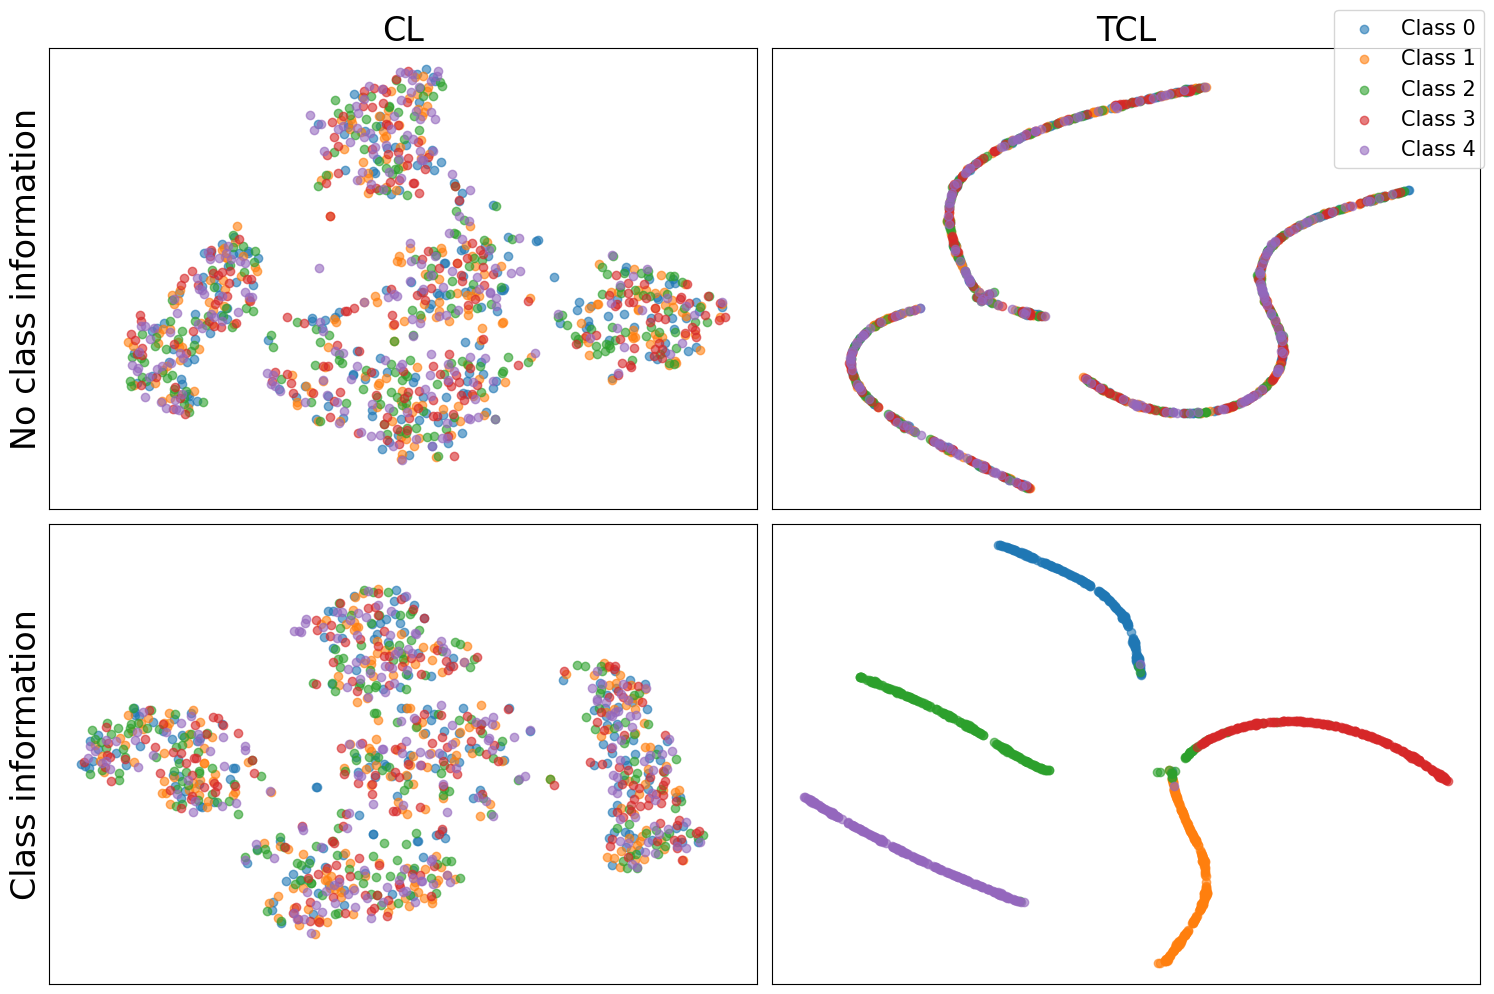

In [32]:
import numpy as np
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt

def save_and_plot_embeddings(embeddings_list, labels, titles, save_dir="saved_embeddings", nrows=2, ncols=2):
    tsne = TSNE(n_components=2, random_state=42)
    
    # Create the directory to save the numpy files if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Create subplots with shared Y-axis within each row and shared X-axis within each column
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharey='row', sharex='col')
    axs = axs.flatten()  # Flatten to easily iterate over

    # Set font sizes (increased as per your instruction)
    title_fontsize = 24
    label_fontsize = 24
    tick_fontsize = 14
    legend_fontsize = 15

    # Adjust titles and labels according to the new layout
    row_titles = ['No class information', 'Class information']
    col_titles = ['CL', 'TCL']

    for i, (embeddings, title) in enumerate(zip(embeddings_list, titles)):
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Save the 2D embeddings as a numpy file
        np.save(os.path.join(save_dir, f"{title.replace(' ', '_')}_2d.npy"), embeddings_2d)
        
        labels_np = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels  # Ensure labels are numpy array
        unique_labels = np.unique(labels_np)
        
        ax = axs[i]
        colors = plt.get_cmap('tab10')  # Use the 'tab10' color palette
        
        for label in unique_labels:
            idx = labels_np == label
            ax.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6, c=[colors(label)])
        
        if i // ncols == 0:  # Set titles only for the first row
            ax.set_title(col_titles[i % ncols], fontsize=title_fontsize)
        if i % ncols == 0:  # Set Y-axis label for the first column in each row
            ax.set_ylabel(row_titles[i // ncols], fontsize=label_fontsize)
        
        # Remove ticks and axis numbers
        ax.tick_params(axis='both', which='both', labelsize=0, length=0)
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust legend placement and fontsize
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=legend_fontsize)
    
    plt.tight_layout()
    plt.show()

# Representations and corresponding titles
embeddings_list = [representations_5, representations_6, representations_5_2, representations_6_2]
titles = ["Standard Embedding Without Class Knowledge", "Standard Embedding With Class Knowledge",
          "Tensorized Embedding Without Class Knowledge", "Tensorized Embedding With Class Knowledge"]

# Save and plot the embeddings
save_and_plot_embeddings(embeddings_list, contra_Y, titles)

